## 4. 決定木
決定木は、意味解釈可能性に配慮する場合に効果のあるモデルである。  
一連の質問に基づいて決断を下すという方法により、データを分類するモデルである。  
決定木の根(ルート)から始めて**情報利得**(分割された集合の要素についてばらつきの減少)が最大となる特徴量で分割する。  
これを葉(リーフ)が純粋(各リーフの訓練データがすべて同じクラスに所属すること)になるまで、この分割を子ノードごとに繰り返す。  
しかし、分割を繰り返すと過学習に陥りやすくなるため、通常は最大の深さに制限を設けて、決定木を**剪定**する。  
  
目的関数は、分割ごとに情報利得(IG)が最大となるように定義される。
$$
IG(D_p,f)=I(D_p)-\sum_{j=1}^m\frac{N_j}{N_p}I(D_j)
$$

ここで、$f$は分割を行う特徴量、$D_p$は親データセット、$D_j$は$j$番目の子ノードのデータセットである。  
$I$は**不純度**を数値化したものであり、$N_p$は親ノードのデータ点数、$N_j$は$j$番目の子ノードのデータ点数である。  
子ノードの不純度が低いほど、情報利得は大きくなる。  
  
ほとんどのライブラリ(schikit-learn含む)は、二分決定木を実装している。
$$
IG(D_p,f)=I(D_p)-\frac{N_{left}}{N_p}I(D_{left})-\frac{N_{right}}{N_p}I(D_{right})
$$

二分決定木でよく使われる不純度の指標または分割条件は、
- ジニ不純度($I_G$)
- エントロピー($I_H$)
- 分類誤差($I_E$)

の3つである。  
#### エントロピー
空ではないクラス$i$を対象に定義する。
$$
I_H(t)=-\sum_{i=1}^cp(i|t)\log_2{p(i|t)}
$$

ここで、$p(i|t)$は、特定のノード$t$においてクラス$i$に所属しているデータ点の割合を表す。  
エントロピーが0となるのは「ノードのデータ点がすべて同じクラスに所属している場合」、  
例えば$p(i=1|t)=1$または$p(i=0|t)=0$の場合である。  
エントロピーが1になるのは、$p(i=1|t)=0.5$および$p(i=0|t)=0.5$で一様に分布している場合である。  
「エントロピーは相互情報量が最大化するように試みる条件である」といえる。  
  
#### ジニ不純度
誤分類の確率を最小化する条件である。
$$
I_G(t)=-\sum_{i=1}^cp(i|t)(1-p(i|t))=1-\sum_{i=1}^cp(i|t)^2
$$

エントロピーと同様に、ジニ不純度が最大となるのは、クラスが完全に混合している場合である。  
実際にエントロピーとジニ不純度では非常によく似た結果になるのが一般的である。  
  
#### 分類誤差
決定木の剪定に役立つ条件であるが、クラス確率の変化に敏感でないため、決定木を成長させるのに適していない。
$$
I_E(t)=1-\max{p(i|t)}
$$

In [24]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X = iris.data[:,[2,3]]
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [25]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0,
                              criterion='gini', # 評価指標 entropy
                              max_depth=None, # 深さの最大数
                              min_samples_split=2, # 分割されるノードにある観測値の最小数
                              min_samples_leaf=1, # ノード内の観測値の最小値
                              min_weight_fraction_leaf=0, # 
                              max_leaf_nodes=None, # リーフ数の最大値
                              min_impurity_decrease=0) # 分割に必要な不純度の低下の最小値

tree.fit(X_train, y_train)

DecisionTreeClassifier(min_impurity_decrease=0, min_weight_fraction_leaf=0,
                       random_state=0)

In [26]:
print("Gini impurity")
print(y_test[:5])
print(tree.predict(X_test[:5]))
print(tree.predict_proba(X_test[:5]))

Gini impurity
[0 1 1 2 0]
[0 1 1 2 0]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [27]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier):
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cuan']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02),
                           np.arange(x2_min, x2_max, 0.02))
    z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, z, alpha=0.3)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl, 0], y=X[y==cl, 1],
                    alpha=0.8,
                    label=cl, 
                    cmap=cmap,
                    edgecolor='black')

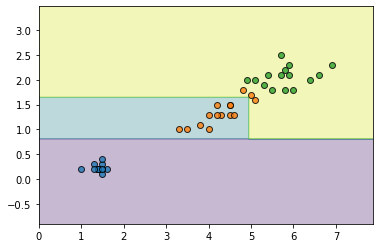

In [28]:
plot_decision_regions(X_test, y_test, tree)

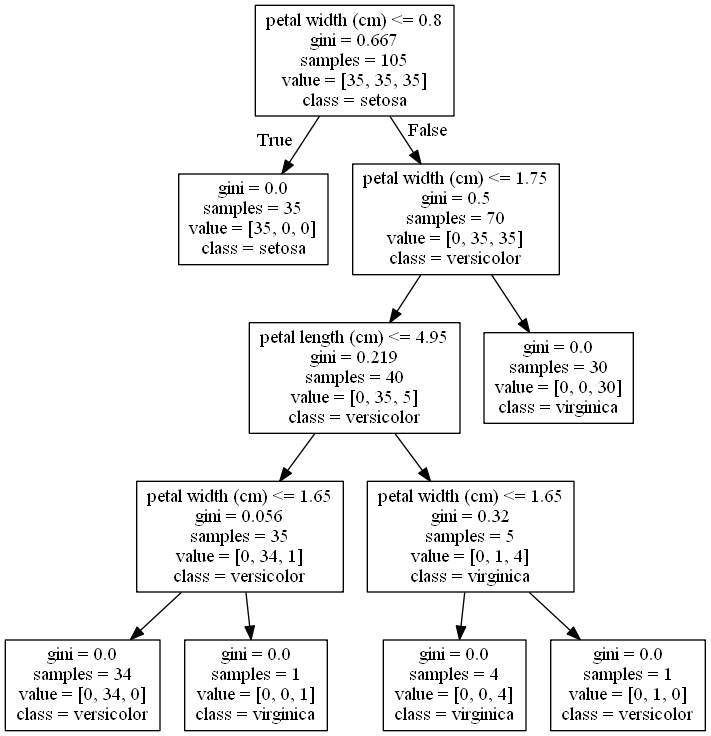

In [16]:
import pydotplus
from IPython.display import Image
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           out_file=None,
                           feature_names=iris.feature_names[2:4],
                           class_names=iris.target_names)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

#### 特徴量の重要度
個々の特徴量がどの程度重要かを示す割合である。  
それぞれの特徴量に対する0と1の間の数で、0は「まったく使われていない」、1は「完全にターゲットを予想できる」を意味する。  
重要であることは教えてくれるが、この値が大きいからどのクラスと判断できるかは教えてくれない。  
また、重要度が低いからと言って、その特徴量が持つ情報が少ないとは限らない。

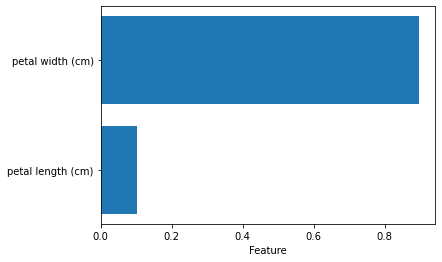

In [39]:
n_features = 2
plt.barh(range(n_features), tree.feature_importances_, align='center');
plt.yticks(np.arange(n_features), iris.feature_names[2:4]);
plt.xlabel("Feature importance");
plt.xlabel("Feature");

#### 回帰木
決定木による回帰モデルは外挿ができないことに注意する。  
深さを大きくすると訓練データにフィットするが、過学習になってしまう。

In [72]:
from sklearn.datasets import load_boston
import pandas as pd

boston = load_boston()

X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

In [73]:
from sklearn.tree import DecisionTreeRegressor

X = X[['LSTAT']].values

tree = DecisionTreeRegressor(max_depth=3)
tree10 = DecisionTreeRegressor(max_depth=10)

tree.fit(X, y)
tree10.fit(X, y)

DecisionTreeRegressor(max_depth=10)

In [69]:
def lin_reg_plot(X, y, model, c, lw):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color=c ,lw=lw)
    return

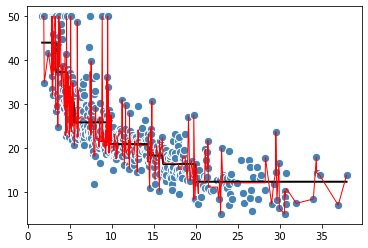

In [74]:
sort_idx = X.flatten().argsort()

lin_reg_plot(X[sort_idx], y[sort_idx], tree, 'black', 2)
lin_reg_plot(X[sort_idx], y[sort_idx], tree10, 'red', 1)